In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# **Part-1 Data Preprocessing**

### 1. Load the data from directory

In [5]:
import pathlib

train_data_dir = pathlib.Path('data/train/')
test_data_dir = pathlib.Path('data/test/')

In [ ]:
print(train_data_dir)

### 2. Displaying images of each class from training dataset

In [7]:
#tr_image_count = len(list(train_data_dir.glob('*/*.jpg'))) + len(list(train_data_dir.glob('*/*.jpeg')))
#te_image_count = len(list(test_data_dir.glob('*/*.jpg'))) + len(list(test_data_dir.glob('*/*.jpeg')))
tr_image_count = len(list(train_data_dir.glob('*/*.*')))
te_image_count = len(list(test_data_dir.glob('*/*.*')))
print(tr_image_count,te_image_count)

251 66


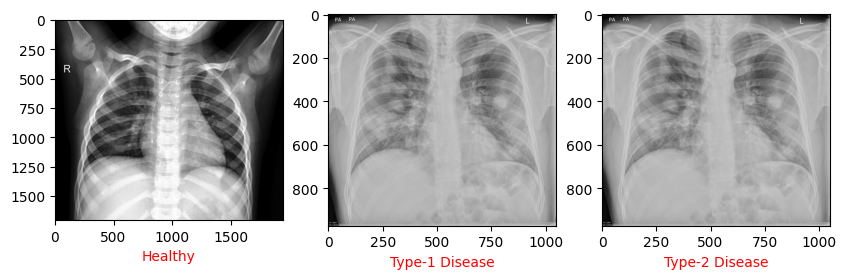

In [8]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)

Healthy = list(train_data_dir.glob('Healthy/*'))
img1= cv2.imread(str(Healthy[0]))
plt.imshow(img1)
plt.xlabel('Healthy', color='red')

plt.subplot(1, 3, 2)
Type_1 = list(train_data_dir.glob('Type1disease/*'))
img2= cv2.imread(str(Type_1[1]))
plt.imshow(img2)
plt.xlabel('Type-1 Disease', color='red')

plt.subplot(1, 3, 3)
Type_2 = list(train_data_dir.glob('Type1disease/*'))
img3= cv2.imread(str(Type_2[1]))
plt.imshow(img3)
plt.xlabel('Type-2 Disease', color='red')

plt.show()

In [9]:
print(img1.shape, img2.shape, img3.shape)

(1708, 1944, 3) (973, 1050, 3) (973, 1050, 3)


### 3. The distribution of images across the classes


In [10]:
print("Total Healthy:{}".format(len(list(train_data_dir.glob('Healthy/*')))+len(list(test_data_dir.glob('Healthy/*')))))
print("Total Type1:{}".format(len(list(train_data_dir.glob('Type1disease/*')))+len(list(test_data_dir.glob('Type1disease/*')))))
print("Total Type2:{}".format(len(list(train_data_dir.glob('Type2disease/*')))+len(list(test_data_dir.glob('Type2disease/*')))))

Total Healthy:90
Total Type1:137
Total Type2:90


### 4.Load data using a Keras utility

In [11]:
batch_size = 32
img_height = 48
img_width = 48

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 251 files belonging to 3 classes.
Using 201 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 251 files belonging to 3 classes.
Using 50 files for validation.


In [14]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 66 files belonging to 3 classes.


### 5.Classes

In [15]:
class_names = train_ds.class_names
print(class_names)

['Healthy', 'Type1disease', 'Type2disease']


### 6. Visualize the data
Here are the first nine images from the training dataset:




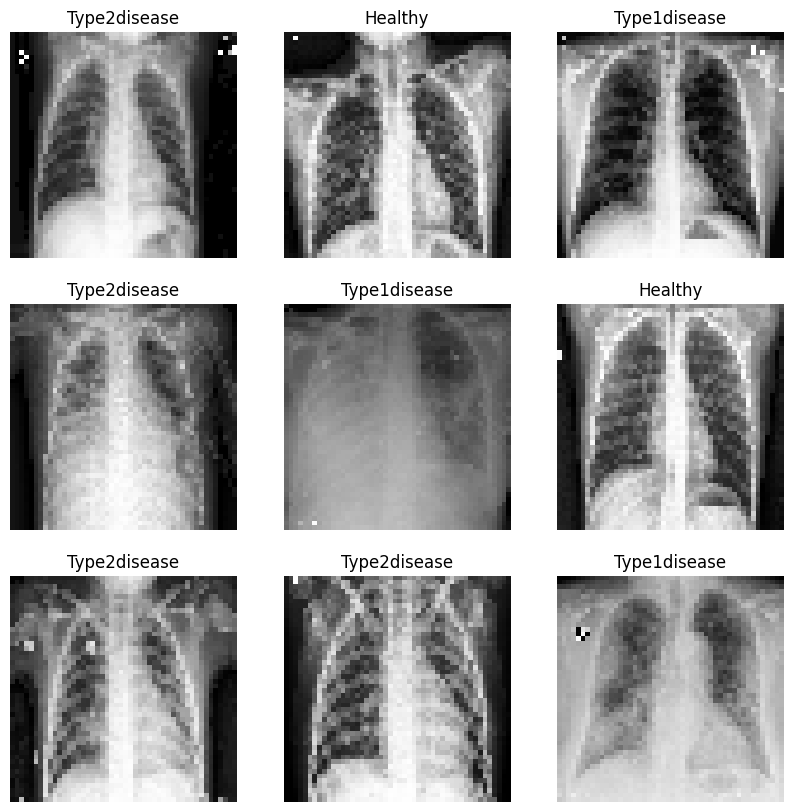

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 48, 48, 3)
(32,)


he `image_batch` is a tensor of the shape `(32, 48, 48, 3)`. This is a batch of 32 images of shape `48x48x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.

### 7. Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.



In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Part - 2 Model Building**

### 1. Standardize the data
The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

## **Model 1 : A basic Keras model**

### 2. Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal  is to show a standard approach.

In [19]:
num_classes = len(class_names)

model1 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [20]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

###  Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [21]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 48, 48, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        1

### Train the model
Train the model for 10 epochs with the Keras `Model.fit` method:

In [22]:
epochs=10
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
7/7 [==============================] - 15s 678ms/step - loss: 1.0810 - accuracy: 0.4428 - val_loss: 1.0023 - val_accuracy: 0.6400
Epoch 2/10
7/7 [==============================] - 1s 101ms/step - loss: 0.9819 - accuracy: 0.5323 - val_loss: 0.8971 - val_accuracy: 0.6800
Epoch 3/10
7/7 [==============================] - 1s 97ms/step - loss: 0.7310 - accuracy: 0.8209 - val_loss: 0.4995 - val_accuracy: 0.9400
Epoch 4/10
7/7 [==============================] - 1s 87ms/step - loss: 0.4814 - accuracy: 0.8209 - val_loss: 0.2537 - val_accuracy: 0.9600
Epoch 5/10
7/7 [==============================] - 1s 86ms/step - loss: 0.3379 - accuracy: 0.8706 - val_loss: 0.1760 - val_accuracy: 0.9400
Epoch 6/10
7/7 [==============================] - 1s 86ms/step - loss: 0.3033 - accuracy: 0.8756 - val_loss: 0.1456 - val_accuracy: 0.9800
Epoch 7/10
7/7 [==============================] - 1s 87ms/step - loss: 0.2235 - accuracy: 0.9055 - val_loss: 0.2006 - val_accuracy: 0.9200
Epoch 8/10
7/7 [========

## 3. Visualize training results
Create plots of the loss and accuracy on the training and validation sets:

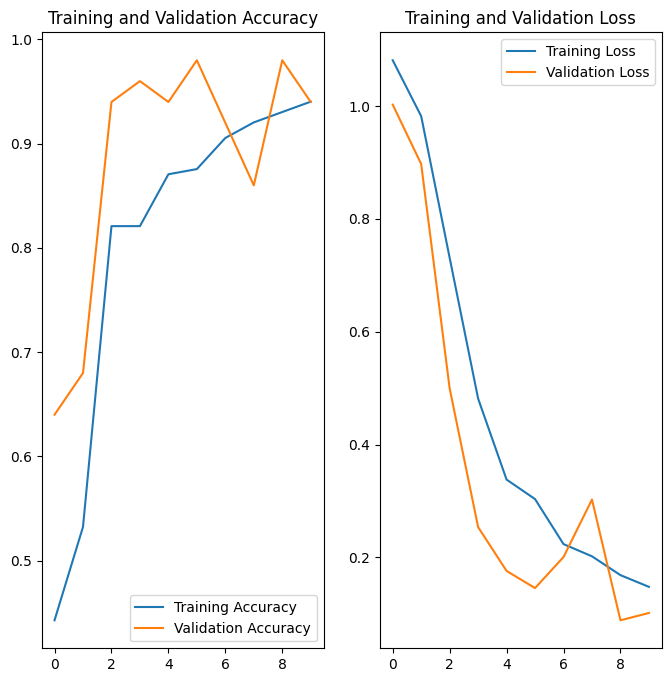

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 4. Evaluate the Model

In [24]:
# Evaluate models and print classification report
from sklearn.metrics import classification_report

# Extract ground truth labels (y_test)
y_test = []
for _, labels in test_ds:
    y_test.extend(labels.numpy())

y_test = np.array(y_test)

# Get predictions from the models
color_predictions = model1.predict(test_ds)

# Convert predictions to class labels
color_pred_labels = np.argmax(color_predictions, axis=1)

# Generate classification reports
color_report = classification_report(y_test, color_pred_labels)

print("Color Model Classification Report:")
print(color_report)

3/3 [==============================] - 0s 36ms/step
Color Model Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.70      0.76        20
           1       0.96      0.88      0.92        26
           2       0.72      0.90      0.80        20

    accuracy                           0.83        66
   macro avg       0.83      0.83      0.83        66
weighted avg       0.85      0.83      0.83        66



# Model 2 : Model using Data Augmentation

### 1. Data Augmentation Layer

In [25]:

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

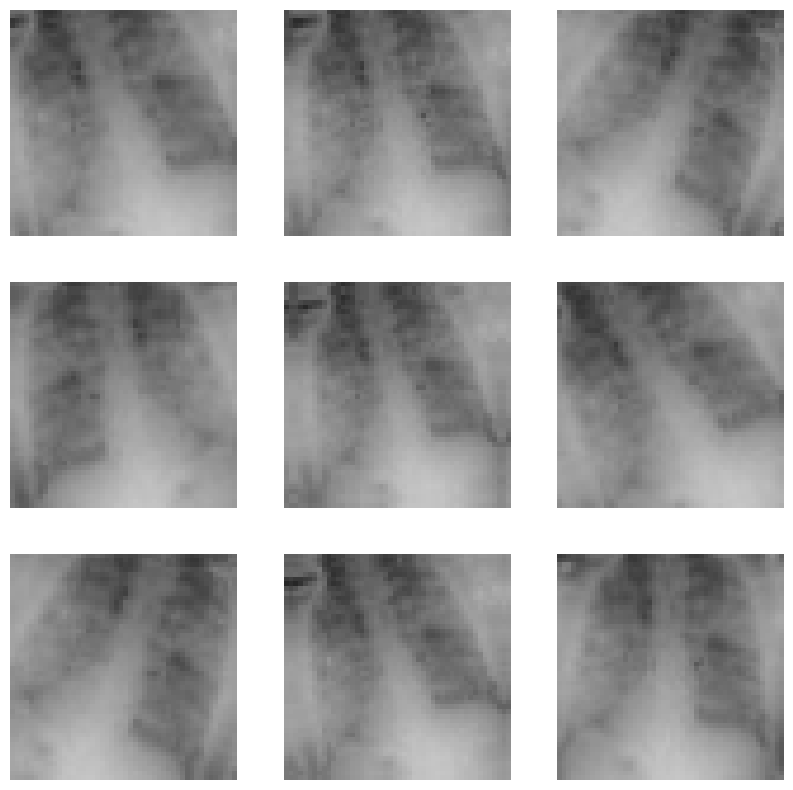

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### 2. Create the model

In [27]:
# We need to scale - lets add the scaling layer in Network itself
num_classes = len(class_names)

model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

### Compile and train the model

In [28]:
model2.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [29]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 48, 48, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                  

### Training

In [30]:
from keras.callbacks import EarlyStopping

epochs=10

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2)


history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  #callbacks=[early_stopping]
)

Epoch 1/10
7/7 [==============================] - 3s 131ms/step - loss: 1.1462 - accuracy: 0.3831 - val_loss: 1.0702 - val_accuracy: 0.4200
Epoch 2/10
7/7 [==============================] - 1s 96ms/step - loss: 1.0237 - accuracy: 0.4975 - val_loss: 1.1720 - val_accuracy: 0.2000
Epoch 3/10
7/7 [==============================] - 1s 96ms/step - loss: 0.9237 - accuracy: 0.5622 - val_loss: 0.8761 - val_accuracy: 0.5600
Epoch 4/10
7/7 [==============================] - 1s 103ms/step - loss: 0.8095 - accuracy: 0.6269 - val_loss: 0.7762 - val_accuracy: 0.7200
Epoch 5/10
7/7 [==============================] - 1s 154ms/step - loss: 0.6667 - accuracy: 0.7612 - val_loss: 0.5920 - val_accuracy: 0.8000
Epoch 6/10
7/7 [==============================] - 1s 188ms/step - loss: 0.6872 - accuracy: 0.7264 - val_loss: 0.7493 - val_accuracy: 0.6000
Epoch 7/10
7/7 [==============================] - 1s 206ms/step - loss: 0.5962 - accuracy: 0.7562 - val_loss: 0.6611 - val_accuracy: 0.7600
Epoch 8/10
7/7 [======

### 3. Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

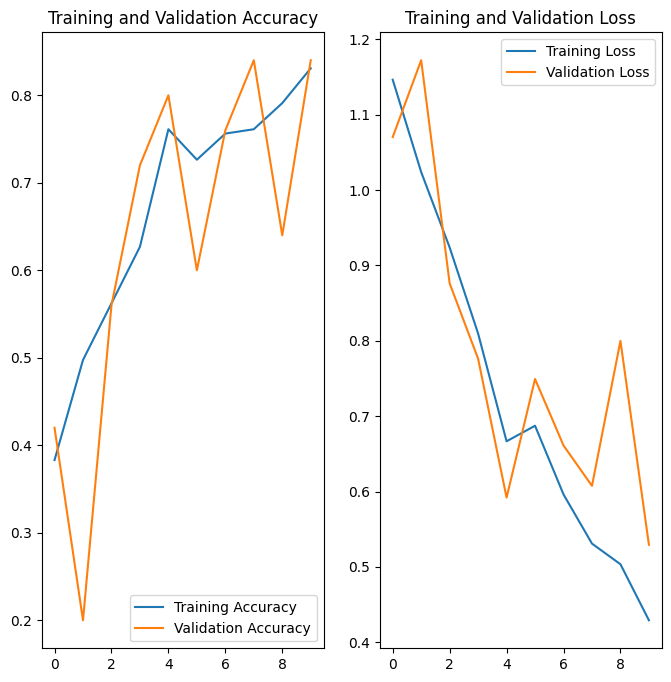

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(len(epochs))
epochs_range = range(len(acc)) # due to early stopping

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 4. Evaluate the Model

In [32]:
# Evaluate models and print classification report
from sklearn.metrics import classification_report

# Extract ground truth labels (y_test)
y_test = []
for _, labels in test_ds:
    y_test.extend(labels.numpy())

y_test = np.array(y_test)

# Get predictions from the models
color_predictions = model2.predict(test_ds)

# Convert predictions to class labels
color_pred_labels = np.argmax(color_predictions, axis=1)

# Generate classification reports
color_report = classification_report(y_test, color_pred_labels)

print("Color Model Classification Report:")
print(color_report)

3/3 [==============================] - 0s 16ms/step
Color Model Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.75      0.64        20
           1       1.00      0.65      0.79        26
           2       0.68      0.75      0.71        20

    accuracy                           0.71        66
   macro avg       0.75      0.72      0.71        66
weighted avg       0.77      0.71      0.72        66



# **Part-3 Transfer learning**

## Model 3 : Using mobile net


### 1. Load the data from directory

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

In [35]:
img_height = 224
img_width = 224
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 251 files belonging to 3 classes.
Using 201 files for training.


In [36]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 251 files belonging to 3 classes.
Using 50 files for validation.


In [37]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 66 files belonging to 3 classes.


In [38]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)

### 2. Create the model

In [39]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE

    return data_augmentation

In [40]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
assert len(augmenter.layers) == 2, "The model must have only 2 layers"

print('\033[92mAll tests passed!')

All tests passed!


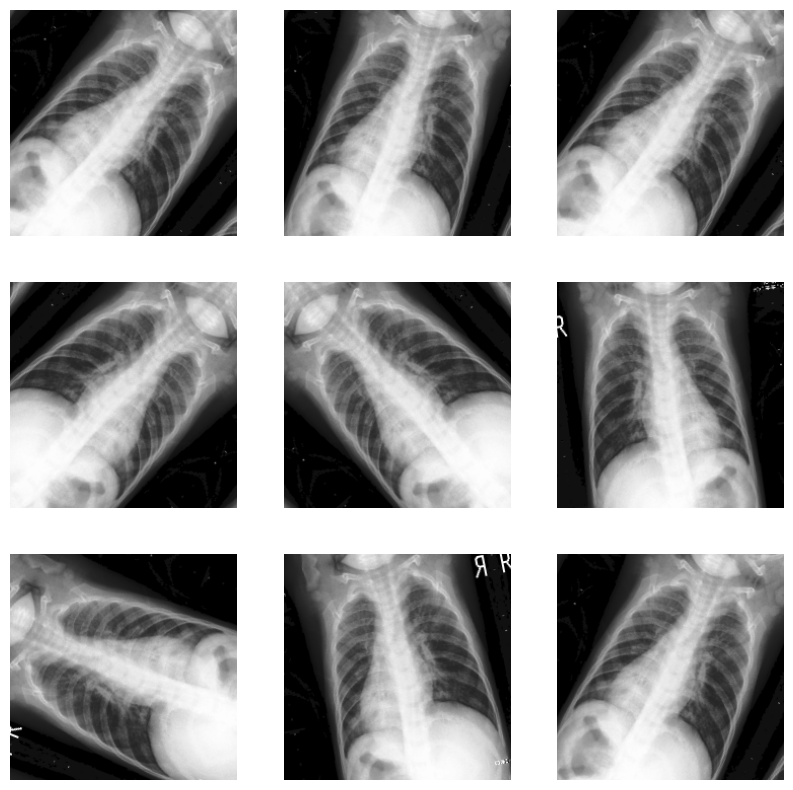

In [41]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Rescale pixel values
The model <a href='https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2'>tf.keras.applications.MobileNetV2</a> expects pixel values in [-1, 1]. To rescale them, use the preprocessing method included with the model.

In [42]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [43]:
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [44]:

nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

Conv_1_bn
out_relu


In [45]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
print(label_batch.shape)

(32, 7, 7, 1280)
(32,)


In [46]:
#Shows the different label probabilities in one tensor
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([2, 1, 2, 0, 2, 1, 1, 2, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 2, 1, 0,
       2, 0, 1, 1, 2, 1, 1, 1, 2, 0], dtype=int32)>

In [47]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

In [48]:
import tensorflow.keras.layers as tfl

def first_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for multiclass classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''


    input_shape = image_shape + (3,)

    ### START CODE HERE

    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet

    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape)

    # apply data augmentation to the inputs
    x = data_augmentation(inputs)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)

    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)
    #include dropout with probability of 0.2 to avoid overfitting
    # x = tfl.Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    # create a prediction layer with one neuron (as a classifier only needs one)

    prediction_layer = Dense(3, activation='softmax')
    ### END CODE HERE

    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [49]:
model3 = first_model(IMG_SIZE, data_augmentation)

In [50]:
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

### Compile and train the model

In [51]:
base_learning_rate = 0.001
from keras.optimizers import RMSprop

model3.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',   # no need of target to be one hot encoded
              metrics=['accuracy'])

### Training

In [53]:
initial_epochs = 10

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

history = model3.fit(train_dataset,
                     validation_data=val_ds,
                     epochs=initial_epochs,
                     #callbacks=[early_stopping]
                     )

Epoch 1/10
7/7 [==============================] - 49s 3s/step - loss: 0.7661 - accuracy: 0.6915 - val_loss: 0.4390 - val_accuracy: 0.8200
Epoch 2/10
7/7 [==============================] - 19s 2s/step - loss: 0.3826 - accuracy: 0.8358 - val_loss: 0.4094 - val_accuracy: 0.8200
Epoch 3/10
7/7 [==============================] - 17s 2s/step - loss: 0.3404 - accuracy: 0.8706 - val_loss: 0.4571 - val_accuracy: 0.8200
Epoch 4/10
7/7 [==============================] - 17s 2s/step - loss: 0.3445 - accuracy: 0.8806 - val_loss: 0.5166 - val_accuracy: 0.7800
Epoch 5/10
7/7 [==============================] - 19s 2s/step - loss: 0.2078 - accuracy: 0.9353 - val_loss: 0.3263 - val_accuracy: 0.8800
Epoch 6/10
7/7 [==============================] - 20s 2s/step - loss: 0.2062 - accuracy: 0.9005 - val_loss: 0.3376 - val_accuracy: 0.8600
Epoch 7/10
7/7 [==============================] - 19s 2s/step - loss: 0.1867 - accuracy: 0.9652 - val_loss: 0.2705 - val_accuracy: 0.9200
Epoch 8/10
7/7 [==================

### 3. Visualize training results

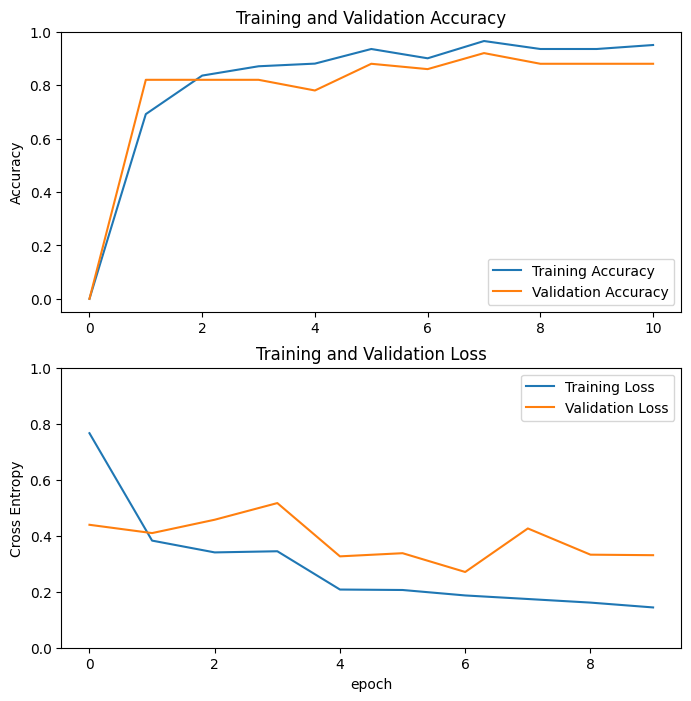

In [54]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### 4. Evaluate the Model

In [55]:
# Evaluate models and print classification report
from sklearn.metrics import classification_report

# Extract ground truth labels (y_test)
y_test = []
for _, labels in test_ds:
    y_test.extend(labels.numpy())

y_test = np.array(y_test)

# Get predictions from the models
color_predictions = model3.predict(test_ds)

# Convert predictions to class labels
color_pred_labels = np.argmax(color_predictions, axis=1)

# Generate classification reports
color_report = classification_report(y_test, color_pred_labels)

print("Color Model Classification Report:")
print(color_report)

3/3 [==============================] - 4s 685ms/step
Color Model Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.35      0.36        20
           1       0.50      0.46      0.48        26
           2       0.30      0.35      0.33        20

    accuracy                           0.39        66
   macro avg       0.39      0.39      0.39        66
weighted avg       0.40      0.39      0.40        66



## Model 3 : Using Densenet121

In [56]:
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)


base_model = tf.keras.applications.DenseNet121(weights="imagenet",
                                               include_top=False,
                                               input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))

29084464/29084464 [==============================] - 0s 0us/step


In [57]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

bn
relu


In [58]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
print(label_batch.shape)

(32, 7, 7, 1024)
(32,)


In [59]:
#Shows the different label probabilities in one tensor
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 1, 0, 1, 2, 0, 1, 0, 1, 1, 1, 2, 1, 0, 0, 0, 1, 0, 1, 2, 1,
       2, 1, 1, 1, 1, 0, 2, 2, 1, 1], dtype=int32)>

In [60]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

1. Create the model

In [61]:
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

def second_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for multiclass classification out of the DenseNet121 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''


    input_shape = image_shape + (3,)

    ### START CODE HERE

    base_model = tf.keras.applications.DenseNet121(weights="imagenet",
                                               include_top=False,
                                               input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))

    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape)

    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    x = Rescaling(1./255)(x)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)

    # construct the head of the model that will be placed on top of the the base model
    x = tfl.GlobalAveragePooling2D()(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)

    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = Dense(3, activation='softmax')


    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [62]:
model4= second_model(IMG_SIZE, data_augmentation)

In [63]:
model4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                           

### 2. Compile and train the model

In [64]:
base_learning_rate = 0.001
from keras.optimizers import Adam


model4.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',   # no need of target to be one hot encoded
              metrics=['accuracy'])

### Training

In [65]:
initial_epochs = 15

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

history = model4.fit(train_dataset,
                     validation_data=val_ds,
                     epochs=initial_epochs,
                     #callbacks=[early_stopping]
                     )

Epoch 1/15
7/7 [==============================] - 73s 9s/step - loss: 1.1847 - accuracy: 0.5124 - val_loss: 0.5400 - val_accuracy: 0.7800
Epoch 2/15
7/7 [==============================] - 52s 7s/step - loss: 0.5357 - accuracy: 0.7761 - val_loss: 0.4078 - val_accuracy: 0.9000
Epoch 3/15
7/7 [==============================] - 52s 7s/step - loss: 0.3471 - accuracy: 0.8657 - val_loss: 0.3332 - val_accuracy: 0.8600
Epoch 4/15
7/7 [==============================] - 52s 7s/step - loss: 0.2911 - accuracy: 0.9005 - val_loss: 0.3024 - val_accuracy: 0.9200
Epoch 5/15
7/7 [==============================] - 51s 7s/step - loss: 0.2936 - accuracy: 0.8905 - val_loss: 0.2762 - val_accuracy: 0.9000
Epoch 6/15
7/7 [==============================] - 62s 9s/step - loss: 0.3338 - accuracy: 0.8955 - val_loss: 0.3093 - val_accuracy: 0.9400
Epoch 7/15
7/7 [==============================] - 50s 7s/step - loss: 0.2501 - accuracy: 0.9055 - val_loss: 0.3229 - val_accuracy: 0.9000
Epoch 8/15
7/7 [==================

### 3. Visualize training results

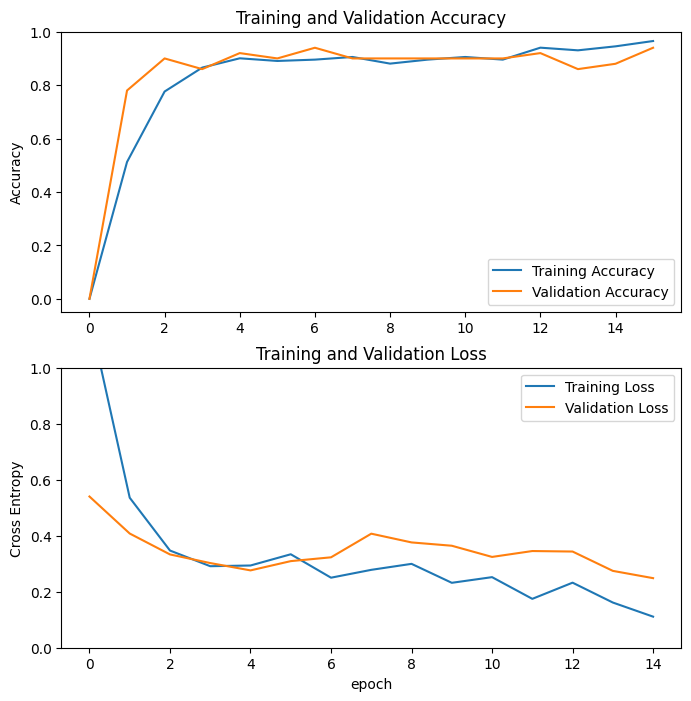

In [67]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### 4. Evaluate the Model

In [66]:
# Evaluate models and print classification report
from sklearn.metrics import classification_report

# Extract ground truth labels (y_test)
y_test = []
for _, labels in test_ds:
    y_test.extend(labels.numpy())

y_test = np.array(y_test)

# Get predictions from the models
color_predictions = model4.predict(test_ds)

# Convert predictions to class labels
color_pred_labels = np.argmax(color_predictions, axis=1)

# Generate classification reports
color_report = classification_report(y_test, color_pred_labels)

print("Color Model Classification Report:")
print(color_report)

3/3 [==============================] - 15s 4s/step
Color Model Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.20      0.21        20
           1       0.35      0.35      0.35        26
           2       0.29      0.30      0.29        20

    accuracy                           0.29        66
   macro avg       0.28      0.28      0.28        66
weighted avg       0.29      0.29      0.29        66

